# Swap Default PySAM WindPower for FLORIS Example
---
In this example, we will show how to change the default [PySAM WindPower](https://nrel-pysam.readthedocs.io/en/main/modules/Windpower.html) wind model to the [FLORIS](https://www.nrel.gov/wind/floris.html) wind model. FLORIS is capable of modeling different steady-state wind wake models and complex turbine interactions. This example is meant to illustrate how the inputs to HOPP change, although it's important to note that FLORIS offers additional adjustable parameters on its side.

### Import Required Modules
We start by importing the necessary modules and setting up our working environment.

In [1]:
from hopp.simulation.hybrid_simulation import HybridSimulation

/Users/kbrunik/github/forked/HOPP/examples/workshop/log/hybrid_systems_2023-10-06T13.50.54.727737.log


### Set Site Information
Set wind and solar resource data at plant location. In this example, we use the Flatirons site as an example location.

In [12]:
from hopp import ROOT_DIR
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site

DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"


site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        solar=True,
        wind=True,
        wave=False
    )

wind_speed = [W[2] for W in site.wind_resource._data['data']]
wind_dirs = [W[3] for W in site.wind_resource._data['data']]

### Define System Capacities
Specify the capacities of the solar, wind, and interconnection components of the hybrid system in megawatts (MW).

In [3]:
solar_size_mw = 50
wind_size_mw = 20
interconnection_size_mw = 50

### Read in FLORIS Configuration
The FLORIS configuration is defined in a `yaml` file that has the wind farm layout and wake models defined.

In [4]:
import yaml

floris_file = "inputs/floris/gch.yaml"
with open(floris_file, 'r') as f:
    floris_config = yaml.load(f, yaml.FullLoader)

### Visualize the Turbine Wakes using FLORIS (Optional) 

Optionally, you can visualize the wakes from the turbines using plotting tools from FLORIS.

 Additional instructions for generating wake plots from floris can be found in [FLORIS plotting example](https://github.com/NREL/floris/blob/main/examples/02_visualizations.py)

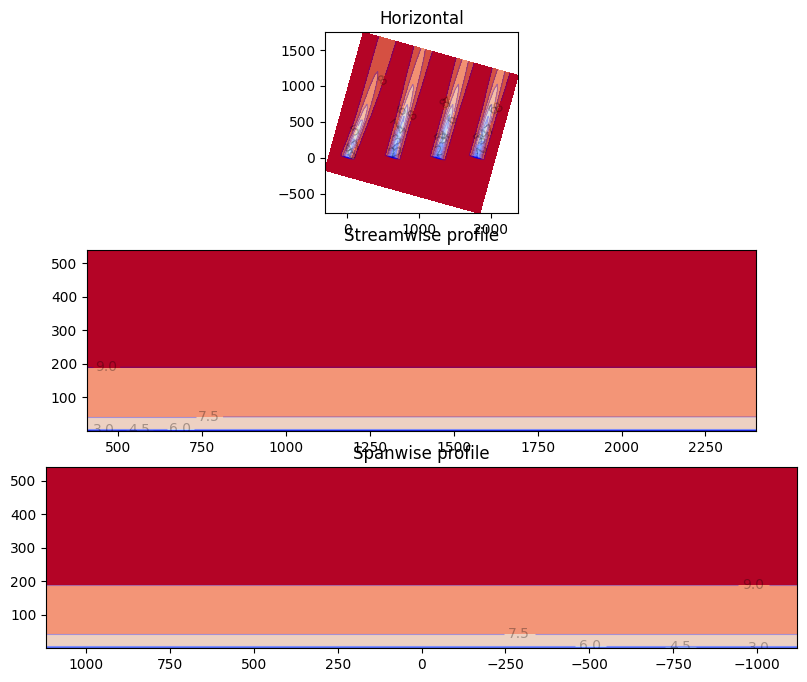

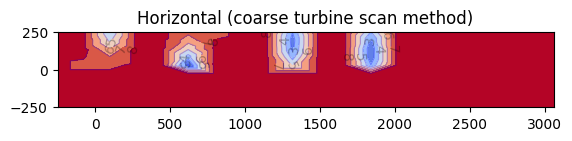

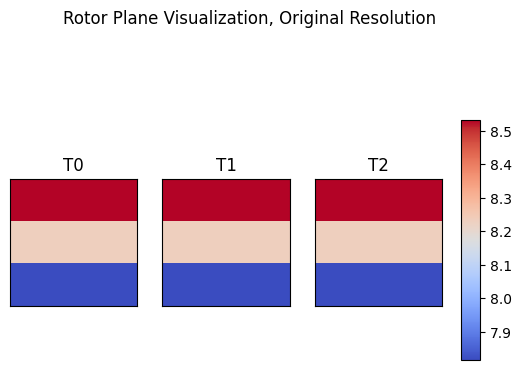

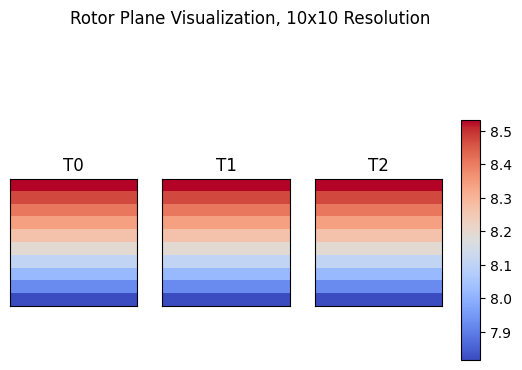

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from floris.tools import FlorisInterface
import floris.tools.visualization as wakeviz
from floris.tools.visualization import visualize_cut_plane
from floris.tools.visualization import plot_rotor_values
from floris.tools.visualization import (
    calculate_horizontal_plane_with_turbines,
    visualize_cut_plane,
)

fi = FlorisInterface("inputs/floris/gch.yaml")
fi.reinitialize(wind_speeds=[np.round(np.average(wind_speed), decimals=3)])
fi.reinitialize(wind_directions=[np.round(np.median(wind_dirs), decimals=2)])
horizontal_plane = fi.calculate_horizontal_plane(
    x_resolution=200,
    y_resolution=100,
    height=90.0,
    yaw_angles=np.array([[[25.,0.,0.,0.]]]),
)

y_plane = fi.calculate_y_plane(
    x_resolution=200,
    z_resolution=100,
    crossstream_dist=0.0,
    yaw_angles=np.array([[[25.,0.,0.,0.]]]),
)
cross_plane = fi.calculate_cross_plane(
    y_resolution=100,
    z_resolution=100,
    downstream_dist=630.0,
    yaw_angles=np.array([[[25.,0.,0.,0.]]]),
)

fig, ax_list = plt.subplots(3, 1, figsize=(10, 8))
ax_list = ax_list.flatten()
wakeviz.visualize_cut_plane(horizontal_plane, ax=ax_list[0], title="Horizontal")
wakeviz.visualize_cut_plane(y_plane, ax=ax_list[1], title="Streamwise profile")
wakeviz.visualize_cut_plane(cross_plane, ax=ax_list[2], title="Spanwise profile")

horizontal_plane_scan_turbine = calculate_horizontal_plane_with_turbines(
    fi,
    x_resolution=20,
    y_resolution=10,
    yaw_angles=np.array([[[25.,0.,0.,0.]]]),
)

fig, ax = plt.subplots()
visualize_cut_plane(
    horizontal_plane_scan_turbine,
    ax=ax,
    title="Horizontal (coarse turbine scan method)",
)

fi.calculate_wake()

fig, axes, _ , _ = wakeviz.plot_rotor_values(
    fi.floris.flow_field.u,
    wd_index=0,
    ws_index=0,
    n_rows=1,
    n_cols=3,
    return_fig_objects=True
)
fig.suptitle("Rotor Plane Visualization, Original Resolution")

solver_settings = {
    "type": "turbine_grid",
    "turbine_grid_points": 10
}
fi.reinitialize(solver_settings=solver_settings)

fi.calculate_wake()

fig, axes, _ , _ = wakeviz.plot_rotor_values(
    fi.floris.flow_field.u,
    wd_index=0,
    ws_index=0,
    n_rows=1,
    n_cols=3,
    return_fig_objects=True
)
fig.suptitle("Rotor Plane Visualization, 10x10 Resolution")

wakeviz.show_plots()

### Define Technologies Configuration
Configure the characteristics of each technology in the system, including PV (solar), wind, and grid interconnection.

**NOTE**: Setting up the wind technology is different from when using PySAM WindPower. You must include the `floris_config` in the wind technology.


In [5]:
technologies = {
    'pv': {
        'system_capacity_kw': solar_size_mw * 1000
    },
    'wind': {
        'num_turbines': 4,
        'turbine_rating_kw':  (wind_size_mw * 1e3) / 4, 
        'model_name': 'floris', 
        'timestep': [0, 8760],
        'floris_config':floris_config,
        'skip_financial': True
        },
    'grid': {
        'interconnect_kw': interconnection_size_mw * 1000
    }
    }

### Create the Hybrid Simulation Model
Create an instance of the `HybridSimulation` class by providing the technology configuration and site information.

**NOTE**: When you create the instance you should see a print out that says `FLORIS is the system model...`

In [6]:
hybrid_plant = HybridSimulation(technologies, site)

FLORIS is the system model...


### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 25 years).

In [7]:
hybrid_plant.simulate(25)

Simulating wind farm output in FLORIS...
Wind annual energy:  71702641.3705228


### Retrieve and Display Results
Access the simulation results, including annual energies, capacity factors and net present values (NPVs), and print them to the console.

In [10]:
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
cf = hybrid_plant.capacity_factors

wind_installed_cost = hybrid_plant.wind.total_installed_cost
solar_installed_cost = hybrid_plant.pv.total_installed_cost
hybrid_installed_cost = hybrid_plant.grid.total_installed_cost

print("Wind Installed Cost: {}".format(wind_installed_cost))
print("Solar Installed Cost: {}".format(solar_installed_cost))
print("Hybrid Installed Cost: {}".format(hybrid_installed_cost))

print("Wind NPV: {}".format(hybrid_plant.net_present_values.wind))
print("Solar NPV: {}".format(hybrid_plant.net_present_values.pv))
print("Hybrid NPV: {}".format(hybrid_plant.net_present_values.hybrid))

print(annual_energies)
print(cf)
print(npvs)

Wind Installed Cost: 72700000.0
Solar Installed Cost: 48000000.0
Hybrid Installed Cost: 120700000.0
Wind NPV: -68746620.18680064
Solar NPV: -35042037.04939877
Hybrid NPV: -104296171.12675565
{"pv": 104053614.17593749, "wind": 71702641.3705228, "hybrid": 175298576.2259878}
{"pv": 23.75653291688071, "wind": 16.370466066329406, "hybrid": 20.063499491605054}
{"pv": -35042037.04939877, "wind": -68746620.18680064, "hybrid": -104296171.12675565}
